In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

import ashrae_constants as const
import prepare_data as prep
import explore_correlations as exp

# Import the data

In [2]:
#only train data needed here
joined_data_dict = prep.get_joined_data(dataset_names=['train'])

Importing data from train_store_joined.h5


In [3]:
train_all_dict = joined_data_dict['train']

In [4]:
small_train_all_dict = prep.produce_and_cache_small_dataset_dict('train')
small_test_all_dict = prep.produce_and_cache_small_dataset_dict('test')

Importing data from train_small_store_joined.h5
Importing data from test_small_store_joined.h5


In [5]:
small_train_all_dict['electricity']

meter  meter_reading   meter_type  site_id  \
building_id timestamp                                                         
0           2016-01-01 00:00:00      0          0.000  electricity        0   
            2016-01-01 01:00:00      0          0.000  electricity        0   
            2016-01-01 02:00:00      0          0.000  electricity        0   
            2016-01-01 03:00:00      0          0.000  electricity        0   
            2016-01-01 04:00:00      0          0.000  electricity        0   
...                                ...            ...          ...      ...   
58          2016-06-30 22:00:00      0        391.448  electricity        0   
            2016-06-30 23:00:00      0        398.956  electricity        0   
            2016-07-01 00:00:00      0        385.305  electricity        0   
            2016-07-01 01:00:00      0        359.709  electricity        0   
            2016-07-01 02:00:00      0        356.979  electricity        0   

                                         primary_use  square_feet  year_built  \
building_id timestamp                                                           
0           2016-01-01 00:00:00            Education         7432      2008.0   
            2016-01-01 01:00:00            Education         7432      2008.0   
            2016-01-01 02:00:00            Education         7432      2008.0   
            2016-01-01 03:00:00            Education         7432      2008.0   
            2016-01-01 04:00:00            Education         7432      2008.0   
...                                              ...          ...         ...   
58          2016-06-30 22:00:00  Lodging/residential        83379      2013.0   
            2016-06-30 23:00:00  Lodging/residential        83379      2013.0   
            2016-07-01 00:00:00  Lodging/residential        83379      2013.0   
            2016-07-01 01:00:00  Lodging/residential        83379      2013.0   
            2016-07-01 02:00:00  Lodging/residential        83379      2013.0   

                                 floor_count  air_temperature  cloud_coverage  \
building_id timestamp                                                           
0           2016-01-01 00:00:00          NaN             25.0        6.000000   
            2016-01-01 01:00:00          NaN             24.4        4.000000   
            2016-01-01 02:00:00          NaN             22.8        2.000000   
            2016-01-01 03:00:00          NaN             21.1        2.000000   
            2016-01-01 04:00:00          NaN             20.0        2.000000   
...                                      ...              ...             ...   
58          2016-06-30 22:00:00          NaN             27.2        5.200000   
            2016-06-30 23:00:00          NaN             26.7        5.600000   
            2016-07-01 00:00:00          NaN             24.4        6.000000   
            2016-07-01 01:00:00          NaN             25.0        6.333333   
            2016-07-01 02:00:00          NaN             24.4        6.666667   

                                 dew_temperature  precip_depth_1_hr  \
building_id timestamp                                                 
0           2016-01-01 00:00:00             20.0               -1.0   
            2016-01-01 01:00:00             21.1               -1.0   
            2016-01-01 02:00:00             21.1                0.0   
            2016-01-01 03:00:00             20.6                0.0   
            2016-01-01 04:00:00             20.0               -1.0   
...                                          ...                ...   
58          2016-06-30 22:00:00             24.0               61.0   
            2016-06-30 23:00:00             23.9                5.0   
            2016-07-01 00:00:00             22.8                5.0   
            2016-07-01 01:00:00             22.8                0.0   
            2016-07-01 02:00:00             2

# 1. Correlate features with meter reading for each building and meter type

In [6]:
CORRELATORS = ['air_temperature', 'cloud_coverage', 'dew_temperature','precip_depth_1_hr', 'sea_level_pressure',
               'wind_direction','wind_speed', 'hour', 'weekday', 'month', 'is_weekend']

In [7]:
hourly_correlations = exp.loop_through_meters_apply_operation(exp.produce_correlation_df,
                                                               train_all_dict,
                                                               correlators=CORRELATORS)

Meter type:  electricity
Meter type:  chilledwater
Meter type:  steam
Meter type:  hotwater


Meter type:  electricity


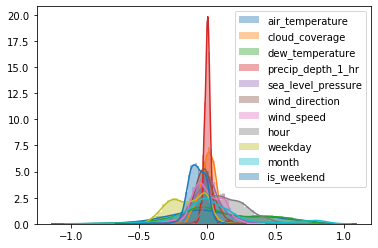

Meter type:  chilledwater


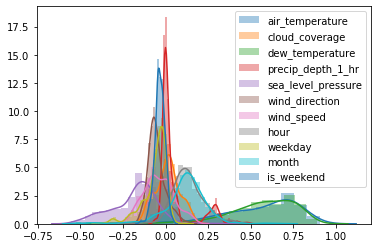

Meter type:  steam


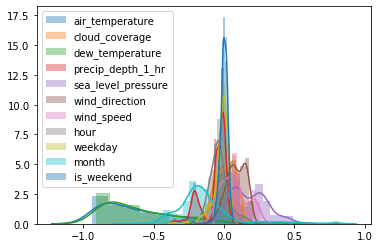

Meter type:  hotwater


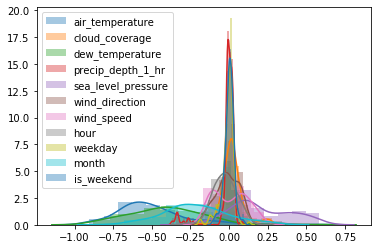

{'electricity': None, 'chilledwater': None, 'steam': None, 'hotwater': None}

In [8]:
exp.loop_through_meters_apply_operation(
    exp.plot_correlation_distribution,
    hourly_correlations)

# 2. Integrate data over a week and look at impact of weather variables then (to take away time dependance)

In [9]:
WEEKLY_ATTRIBUTES = ['meter_reading','air_temperature', 'cloud_coverage', 'dew_temperature','precip_depth_1_hr',
                     'sea_level_pressure', 'wind_direction','wind_speed', 'week_number', 'month']
WEEKLY_CORRELATORS = ['air_temperature', 'cloud_coverage', 'dew_temperature','precip_depth_1_hr',
                      'sea_level_pressure', 'wind_direction','wind_speed', 'month']

In [10]:
set_point_C = 13
weekly_means_dict= {meter_type: exp.produce_weekly_average_data(df, weekly_attributes=WEEKLY_ATTRIBUTES)
                           for meter_type, df in train_all_dict.items()}
weekly_dh_dict = {meter_type: exp.produce_weekly_degree_hours(df, set_point_C)
                           for meter_type, df in train_all_dict.items()}

In [11]:
weekly_mean_correlations = exp.loop_through_meters_apply_operation(exp.produce_correlation_df,
                                                                weekly_means_dict,
                                                                correlators=WEEKLY_CORRELATORS)
weekly_dh_correlations = exp.loop_through_meters_apply_operation(exp.produce_correlation_df,
                                                                weekly_dh_dict,
                                                                correlators=['delta_temp'])

Meter type:  electricity
Meter type:  chilledwater
Meter type:  steam
Meter type:  hotwater
Meter type:  electricity
Meter type:  chilledwater
Meter type:  steam
Meter type:  hotwater


Meter type:  electricity


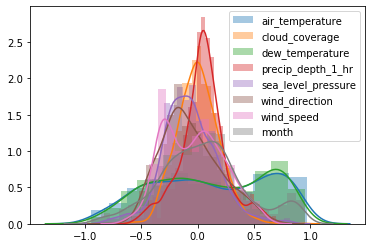

Meter type:  chilledwater


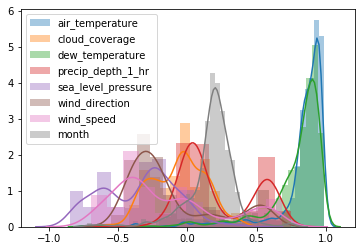

Meter type:  steam


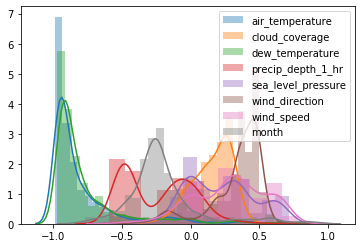

Meter type:  hotwater


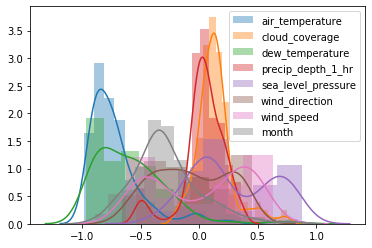

{'electricity': None, 'chilledwater': None, 'steam': None, 'hotwater': None}

In [12]:
exp.loop_through_meters_apply_operation(
    exp.plot_correlation_distribution,
    weekly_mean_correlations)

Meter type:  electricity


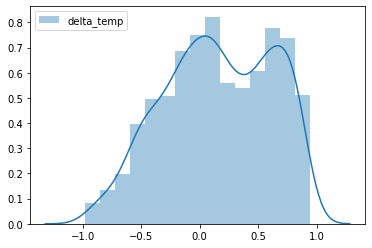

Meter type:  chilledwater


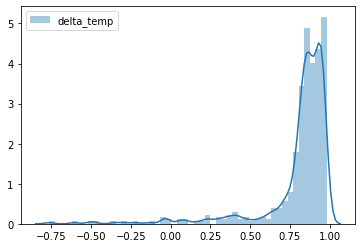

Meter type:  steam


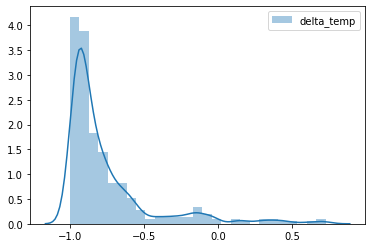

Meter type:  hotwater


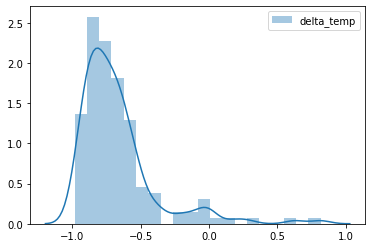

{'electricity': None, 'chilledwater': None, 'steam': None, 'hotwater': None}

In [13]:
exp.loop_through_meters_apply_operation(
    exp.plot_correlation_distribution,
    weekly_dh_correlations)

## 3. Compare strength of different correlators

Meter type:  electricity


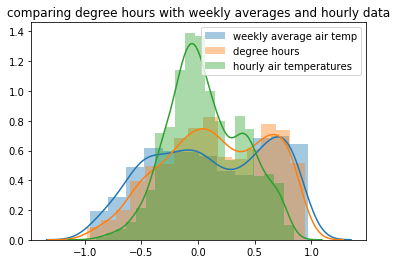

Meter type:  chilledwater


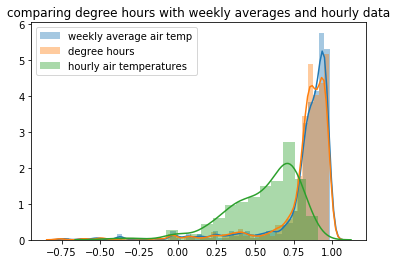

Meter type:  steam


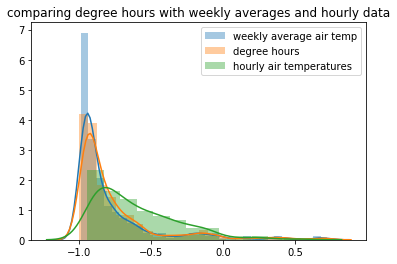

Meter type:  hotwater


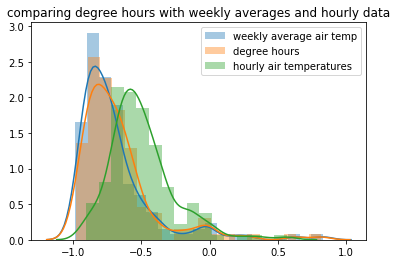

In [27]:
for meter_type in weekly_mean_correlations.keys():
        print("Meter type: ", meter_type)
        exp.compare_distributions(
            {'weekly average air temp': weekly_mean_correlations[meter_type]['air_temperature'],
             'degree hours': weekly_dh_correlations[meter_type]['delta_temp'],
             'hourly air temperatures':hourly_correlations[meter_type]['air_temperature']},
            'comparing degree hours with weekly averages and hourly data')

# 3. Linear regression model based on air temperature only

Assume that form of equation is meter_reading = A.T(t) + B + f(t) where B = A.T_setpoint. <br>

In [ ]:
def fit_linear_regression_to_air_temp_data(df):
    
    building_ids = list(set(df.index.get_level_values('building_id')))
    df_results = pd.DataFrame(index=building_ids, columns = ['r_sq', 'intercept', 'temp_coef', 'set_point_temp'])
    df_results.index.rename('building_id', inplace=True)
    
    for building_id in building_ids:
        building_df = df.loc[building_id]
        y=building_df['meter_reading'].to_numpy()
        x=building_df['air_temperature'].to_numpy().reshape(-1, 1)
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
        x=imp_mean.fit_transform(x)
        model=LinearRegression(n_jobs=-1).fit(x,y)
        r_sq = model.score(x, y)
        df_results.loc[building_id, 'r_sq'] = r_sq
        df_results.loc[building_id, 'intercept'] = model.intercept_
        df_results.loc[building_id, 'temp_coef'] = model.coef_[0]
        df_results.loc[building_id, 'set_point_temp'] = -model.intercept_/model.coef_[0]
        
    for col in list(df_results):
        df_results[col] = pd.to_numeric(df_results[col])
        
    return df_results

In [ ]:
#alternative where you throw away weeks that have 0 average meter reading for that week - save that week number

## 3.1 Air temperature - weekly averages

Integrate out the time dependancy by looking at entire weeks

Start by just fitting a from weekly_meter_reading = A.T_mean + B

In [ ]:
building_df = steam_weekly_means_df.loc[745]
y=building_df['meter_reading'].to_numpy()
x=building_df['air_temperature'].to_numpy()
plt.xlabel('air temp')
plt.ylabel('meter reading')
plt.scatter(x,y)
plt.show()

In [ ]:
building_df = steam_weekly_means_df.loc[1442]
y=building_df['meter_reading'].to_numpy()
x=building_df['air_temperature'].to_numpy()
plt.xlabel('air temp')
plt.ylabel('meter reading')
plt.scatter(x,y)
plt.show()

### 3.1.1 Fit model

In [ ]:
df_steam_weekly_results = fit_linear_regression_to_air_temp_data(steam_weekly_means_df)
df_chilledwater_weekly_results = fit_linear_regression_to_air_temp_data(chilledwater_weekly_means_df)
df_hotwater_weekly_results = fit_linear_regression_to_air_temp_data(hotwater_weekly_means_df)
df_elec_weekly_results = fit_linear_regression_to_air_temp_data(elec_weekly_means_df) 

In [ ]:
#stick them all together for use later
df_elec_weekly_results['meter'] = 0
df_chilledwater_weekly_results['meter'] = 1
df_steam_weekly_results['meter'] = 2
df_hotwater_weekly_results['meter'] = 3


df_weekly_results = pd.concat([df_elec_weekly_results, df_chilledwater_weekly_results,
           df_hotwater_weekly_results, df_steam_weekly_results])

In [ ]:
METERS_NUMBER_NAME = {0: 'elec', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
def compare_variables_in_df_between_meters(df, variables, meters_number_name = METERS_NUMBER_NAME):
    for variable in variables:
        variable_name_dict = {}
        df_dict = {}
        for meter_no, meter_name in meters_number_name.items():
            variable_name_dict[meter_name] = variable
            df_dict[meter_name] = df[df.meter == meter_no]
        #print(variable_name_dict)
        #print(df_dict)
        compare_distributions(df_dict, variable_name_dict, variable)

In [ ]:
compare_variables_in_df_between_meters(df_weekly_results, ['r_sq', 'temp_coef', 'set_point_temp'])

In [ ]:
# so there are some very non-physical results for temp coef and set point temp in the steam data set
#and the ? elec? dataset.Plot seperately to be sure which datasets have odd results

In [ ]:
compare_variables_in_df_between_meters(df_weekly_results, ['r_sq', 'temp_coef', 'set_point_temp'],
                                      meters_number_name={0: 'elec'})

In [ ]:
compare_variables_in_df_between_meters(df_weekly_results, ['r_sq', 'temp_coef', 'set_point_temp'],
                                      meters_number_name={1: 'chilledwater'})

In [ ]:
compare_variables_in_df_between_meters(df_weekly_results, ['r_sq', 'temp_coef', 'set_point_temp'],
                                      meters_number_name={1: 'hotwater'})

In [ ]:
compare_variables_in_df_between_meters(df_weekly_results, ['r_sq', 'temp_coef', 'set_point_temp'],
                                      meters_number_name={2: 'steam'})

In [ ]:
for meter_no, meter_name in METERS_NUMBER_NAME.items():
    df_to_plot = df_weekly_results[df_weekly_results.meter == meter_no]
    plt.scatter(df_to_plot.index, df_to_plot.temp_coef)
    plt.title(meter_name + " temp coeff")
    plt.show()
    plt.scatter(df_to_plot.index, df_to_plot.set_point_temp)
    plt.title(meter_name + " set point temp")
    plt.show()
    

In [ ]:
# All have some very unphysical values in there. Leave for now but maybe address later

In [ ]:
chilledwater_weekly_means_df[chilledwater_weekly_means_df.meter_reading < 1]

In [ ]:
elec_weekly_means_df[elec_weekly_means_df.meter_reading < 1]

In [ ]:
buildings_no_elec_week = set(elec_weekly_means_df.building_id[elec_weekly_means_df.meter_reading < 1])

In [ ]:
steam_weekly_means_df[steam_weekly_means_df.meter_reading < 1]

In [ ]:
hotwater_weekly_means_df[hotwater_weekly_means_df.meter_reading < 1]

In [ ]:
hotwater_weekly_means_df

### 3.1.2 Compare R squared values from weekly averages between building primary uses

In [ ]:
#add data on building primary use to explore impact
df_elec_weekly_results_buildtype = df_elec_weekly_results.join(building['primary_use'])
df_steam_weekly_results_buildtype = df_steam_weekly_results.join(building['primary_use'])
df_chilledwater_weekly_results_buildtype = df_chilledwater_weekly_results.join(building['primary_use'])
df_hotwater_weekly_results_buildtype = df_hotwater_weekly_results.join(building['primary_use'])

In [ ]:
def compare_building_uses(df, building, variable, title):
    for use in set(building['primary_use']):
        sns.distplot(list(df[df['primary_use']==use][variable].dropna()), label=use)
        plt.title(title)
        # Put the legend out of the figure
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [ ]:
compare_building_uses(df_elec_weekly_results_buildtype, building, 'r_sq',
                      "Electric meter - comparison of Rsq between building types")
compare_building_uses(df_chilledwater_weekly_results_buildtype, building,'r_sq',
                      "Chilled Water meter - comparison of Rsq between building types")
compare_building_uses(df_steam_weekly_results_buildtype, building, 'r_sq',
                      "Steam meter - comparison of Rsq between building types")
compare_building_uses(df_hotwater_weekly_results_buildtype, building,'r_sq',
                      "Hot water meter - comparison of R-sq between building types")

In [ ]:
del df_elec_weekly_results_buildtype, df_steam_weekly_results_buildtype
del df_chilledwater_weekly_results_buildtype
del df_hotwater_weekly_results_buildtype 

### 3.1.3 Apply coefficients to hourly dataset

In [ ]:
def add_temp_based_predictions(df, df_lin_reg_results):
    
    df = df.reset_index()
    df_lin_reg_results = df_lin_reg_results[['r_sq', 'temp_coef', 'intercept',
                                             'set_point_temp', 'meter']].reset_index()
    df = df.merge(df_lin_reg_results, how='left', on=['building_id', 'meter'])
    df = df.set_index(['building_id', 'timestamp'])
    
    df['temp_based_prediction'] = df['temp_coef'] * df['air_temperature'] + df['intercept']
    
    # remove sub-zero predictions
    df['temp_based_prediction'].loc[:,df['temp_based_prediction'] < 0] = 0
    
    if 'meter_reading' in df.columns:
        df['residual'] = df['meter_reading'] - df['temp_based_prediction']
        df['squared_log_error'] = (np.log(df['temp_based_prediction'] + 1) - np.log(df['meter_reading'] + 1))**2
    return df

In [ ]:
elec_train_weekly_temp_preds = add_temp_based_predictions(elec_train, df_elec_weekly_results)
chilledwater_train_weekly_temp_preds = add_temp_based_predictions(chilledwater_train,
                                                                  df_chilledwater_weekly_results)
hotwater_train_weekly_temp_preds = add_temp_based_predictions(hotwater_train, df_hotwater_weekly_results)
steam_train_weekly_temp_preds = add_temp_based_predictions(steam_train, df_steam_weekly_results)

In [ ]:
hotwater_train_weekly_temp_preds

In [ ]:
hotwater_train_weekly_temp_preds.loc[1331,'meter_reading'].plot()

In [ ]:
hotwater_train_weekly_temp_preds.loc[1331,'temp_based_prediction'].plot()

In [ ]:
hotwater_train_weekly_temp_preds.loc[106,'meter_reading'].plot()

In [ ]:
hotwater_train_weekly_temp_preds.loc[106,'temp_based_prediction'].plot()

Heating gets turned off in the summer. This impact is making the linear fit insufficiently sensitive to temperature for the rest of the year. Try to account for this before doing linear fit? TODO

In [ ]:
# look for weeks with zero values


In [ ]:
def plot_timeseries(df, variable, building_id, timestamp_start=None, timestamp_end=None, title=""):
    
    df = df.loc[building_id]
    y2=df.loc[slice(timestamp_start, timestamp_end),variable].to_numpy()
    x2=df.loc[slice(timestamp_start, timestamp_end)].index.get_level_values('timestamp').to_numpy()
    plt.xlabel('timestamp')
    plt.ylabel(variable)
    plt.scatter(x2,y2)
    plt.title(title)
    plt.show()
    

In [ ]:
# plot the squared_log_error for a few dfs
plot_timeseries(elec_train_weekly_temp_preds, 'squared_log_error', 745, title='elec')
plot_timeseries(chilledwater_train_weekly_temp_preds, 'squared_log_error', 745, title='chilled water')
plot_timeseries(hotwater_train_weekly_temp_preds, 'squared_log_error', 106, title='hotwater')
plot_timeseries(steam_train_weekly_temp_preds, 'squared_log_error', 745, title='steam')

plot_timeseries(steam_train_weekly_temp_preds, 'squared_log_error', 1442, title='steam - building 1442')   
plot_timeseries(steam_train_weekly_temp_preds, 'squared_log_error', 1442, title='steam - building 1442 zoomed in',
                timestamp_start='2016-01-01 00:00:00',
                timestamp_end='2016-01-03 00:00:00') # not working nicely...


In [ ]:
#suprisingly - elec data looks the best in many ways. How can this be when temp a poor correlator?
#hot water increases in the summer and decreases in the winter - add cut off temp?
# perhaps just because some very odd/erroneous values in the other datasets? Maybe the 0 values?

In [ ]:
#plot the distribution of the log squared errors
def compare_distributions(df_dict, variable_name_dict, title):
    for df_name, df in df_dict.items():
        sns.distplot(list(df[variable_name_dict[df_name]].dropna()), label=df_name)
    plt.title(title)
    plt.legend()
    plt.show()
    
variable_name_dict = {'elec': 'squared_log_error',
                      'chilledwater':'squared_log_error',
                      'hotwater':'squared_log_error', 
                      'steam':'squared_log_error'}

df_dict_compare_errors = {'elec': elec_train_weekly_temp_preds,
                             'chilledwater': chilledwater_train_weekly_temp_preds,
                             'hotwater':hotwater_train_weekly_temp_preds,
                             'steam': steam_train_weekly_temp_preds}

compare_distributions(df_dict_compare_errors ,
                      variable_name_dict,
                     'Comparing residual/actual for electricity, chilled water, hotwater and steam')    

In [ ]:
#some issues with huge erros in the steam and chilled water datasets - need to find them

In [ ]:
steam_train_weekly_temp_preds

### 3.1.4 Evaluate performance of simple linear regression based on weekly averages

In [ ]:
def extract_predictions(df, column_header):
    predictions = df[column_header].to_numpy()
    predictions[predictions < 0] = 0
    return predictions

In [ ]:
#elec
elec_predictions = extract_predictions(elec_train_weekly_temp_preds,'temp_based_prediction')
elec_actuals = elec_train_weekly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(elec_predictions, elec_actuals)

In [ ]:
#chilledwater
chilledwater_predictions = extract_predictions(chilledwater_train_weekly_temp_preds,'temp_based_prediction')
chilledwater_actuals = chilledwater_train_weekly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(chilledwater_predictions, chilledwater_actuals)

In [ ]:
#hotwater
hotwater_predictions = extract_predictions(hotwater_train_weekly_temp_preds,'temp_based_prediction')
hotwater_actuals = hotwater_train_weekly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(hotwater_predictions, hotwater_actuals)

In [ ]:
#steam
steam_predictions = extract_predictions(steam_train_weekly_temp_preds,'temp_based_prediction')
steam_actuals = steam_train_weekly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(steam_predictions, steam_actuals)

In [ ]:
# all together
predictions = np.concatenate([elec_predictions, chilledwater_predictions,hotwater_predictions, steam_predictions])
actuals = np.concatenate([elec_actuals, chilledwater_actuals,hotwater_actuals, steam_actuals])
calculate_RMSLE_score(predictions, actuals)

### 3.1.5 Produce a set of predictions on the test set based on this weekly average temperature model

In [ ]:
def add_weather_variables_to_test_df(test, building, weather, weather_variables):
    
    # add site id to test data
    building_site_id = building[['site_id','building_id']].set_index('building_id').to_dict()['site_id']
    test_with_site_id = test.copy()
    test_with_site_id['site_id'] = test_with_site_id['building_id'].map(building_site_id )
    
    # add required weather variables to test data
    required_weather = weather[['site_id', 'timestamp'] + weather_variables]
    all_df = test_with_site_id.merge(required_weather, on = ['site_id', 'timestamp'], how='left')
    
    #multi index on building id and timestamp to match previous format
    all_df = all_df.set_index(['building_id', 'timestamp']).sort_index()
    
    return all_df

In [ ]:
test_with_air_temp = add_weather_variables_to_test_df(test, building, weather_test, ['air_temperature'])

In [ ]:
# very slow
test_weekly_temp_preds = add_temp_based_predictions(test_with_air_temp, df_weekly_results)

In [ ]:
test_with_air_temp

In [ ]:
test_weekly_temp_preds

In [ ]:
predictions = test_weekly_temp_preds[['row_id', 'temp_based_prediction']].copy()
predictions = predictions.reset_index()[['row_id', 'temp_based_prediction']]
predictions = predictions.set_index('row_id')
predictions = predictions.rename(columns = {'temp_based_prediction':'meter_reading'})
predictions = predictions.sort_index(0)

In [ ]:
predictions

In [ ]:
#predictions.to_csv('weekly_temp_means_submission.csv')

In [ ]:
len(predictions)

### 3.1.6 Look at what correlates with the residuals

In [ ]:
elec_residuals_corr = produce_correlation_df(elec_train_weekly_temp_preds, y_variable='residual')
hotwater_residuals_corr = produce_correlation_df(hotwater_train_weekly_temp_preds, y_variable='residual')
chilledwater_residuals_corr = produce_correlation_df(chilledwater_train_weekly_temp_preds, y_variable='residual')
steam_residuals_corr = produce_correlation_df(steam_train_weekly_temp_preds, y_variable='residual')

In [ ]:
explore_correlations(elec_residuals_corr)

In [ ]:
explore_correlations(chilledwater_residuals_corr)

In [ ]:
explore_correlations(hotwater_residuals_corr)

In [ ]:
explore_correlations(steam_residuals_corr)

In [ ]:
# Hmm - why is there any signal left in air temp? I suppose the temperature dependance is not independant of time.
# Perhaps because the set point temperature changes with time
# Time seems important. As a dump option, try and just add the whole residual back onto the test set?


### 3.1.7 Add residuals back in to temp based predictions 

This will obviously give perfect results here but worth a submission attempt in case it works well
Won't deal with the variation in set point temperature well but should do an ok job with the other time dependance

In [ ]:
elec_resids = elec_train_weekly_temp_preds[['meter', 'residual']]
hotwater_resids = hotwater_train_weekly_temp_preds[['meter', 'residual']]
steam_resids = steam_train_weekly_temp_preds[['meter', 'residual']]
chilledwater_resids = chilledwater_train_weekly_temp_preds[['meter', 'residual']]

In [ ]:
all_resids = elec_resids.append([hotwater_resids, steam_resids, chilledwater_resids ])

In [ ]:
all_resids

In [ ]:
test_weekly_temp_preds

## 3.2 Air temperaure - hourly data

### 3.2.1 Fit to hourly data

In [ ]:
df_steam_hourly_results = fit_linear_regression_to_air_temp_data(steam_train)
df_chilledwater_hourly_results = fit_linear_regression_to_air_temp_data(chilledwater_train)
df_hotwater_hourly_results = fit_linear_regression_to_air_temp_data(hotwater_train)
df_elec_hourly_results = fit_linear_regression_to_air_temp_data(elec_train) 

In [ ]:
#add meter numbers (this is kinda silly - should just keep them in earlier)
df_elec_hourly_results['meter'] = 0
df_chilledwater_hourly_results['meter'] = 1
df_steam_hourly_results['meter'] = 2
df_hotwater_hourly_results['meter'] = 3

In [ ]:
variable_name_dict = {'steam':'r_sq',
                      'hotwater':'r_sq',
                      'chilledwater':'r_sq',
                      'elec':'r_sq'}

compare_distributions({'steam':df_steam_weekly_results,
                      'hotwater': df_hotwater_weekly_results,
                      'chilledwater':df_chilledwater_weekly_results,
                      'elec': df_elec_weekly_results},
                      variable_name_dict,
                      'r_sq - based on weekly means')

compare_distributions({'steam':df_steam_hourly_results,
                      'hotwater': df_hotwater_hourly_results,
                      'chilledwater':df_chilledwater_hourly_results,
                      'elec': df_elec_hourly_results},
                      variable_name_dict,
                      'r_sq - based on hourly data')

### 3.2.3 Evaluate performance of simple linear regression based on hourly temp data

In [ ]:
elec_train_hourly_temp_preds = add_temp_based_predictions(elec_train, df_elec_hourly_results)
chilledwater_train_hourly_temp_preds = add_temp_based_predictions(chilledwater_train,
                                                                  df_chilledwater_hourly_results)
hotwater_train_hourly_temp_preds = add_temp_based_predictions(hotwater_train, df_hotwater_hourly_results)
steam_train_hourly_temp_preds = add_temp_based_predictions(steam_train, df_steam_hourly_results)

In [ ]:
elec_predictions = extract_predictions(elec_train_hourly_temp_preds,'temp_based_prediction')
elec_actuals = elec_train_hourly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(elec_predictions, elec_actuals)

In [ ]:
chilledwater_predictions = extract_predictions(chilledwater_train_hourly_temp_preds,'temp_based_prediction')
chilledwater_actuals = chilledwater_train_hourly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(chilledwater_predictions, chilledwater_actuals)

In [ ]:
hotwater_predictions = extract_predictions(hotwater_train_hourly_temp_preds,'temp_based_prediction')
hotwater_actuals = hotwater_train_hourly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(hotwater_predictions, hotwater_actuals)

In [ ]:
steam_predictions = extract_predictions(steam_train_hourly_temp_preds,'temp_based_prediction')
steam_actuals = steam_train_hourly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(steam_predictions, steam_actuals)

In [ ]:
# all together
predictions = np.concatenate([elec_predictions, chilledwater_predictions,hotwater_predictions, steam_predictions])
actuals = np.concatenate([elec_actuals, chilledwater_actuals,hotwater_actuals, steam_actuals])
calculate_RMSLE_score(predictions, actuals)

In [ ]:
# so the hourly model actually does better. Perhaps because it intrinsically deals with some time dependance?

# Learnings

- Weather data is for 1 year - 2016
- Their are 16 sites we have weather data for
- Temperature data is good - no missing values. Other weather data less so. 
- Weather data and meter data is missing some hours of the year. Meter data has all hours that weather data has
- No clear pattern to where data is missing
<br/>

- There can be multiple meters per building
- We need to learn seperate models for each meter. It may be hard to generalise learnings for the same building. 
- We need to predict meter readings hourly
<br/>

- Weekly mean air temperature strongly and consistently correlates with mean meter reading for all meaters apart from electricity 
- Weekly degree hours also strongly correlation with total weekly consumption - but relationship is slightly less good than for averages. Could be because of the changing balance point
- Other weather data not particularly important - so start with temperature
- Time dependance not really explored yet - instead learning attibutes about temperature dependance based on weekly data and then using those for hourly data
- The strength of temperature as a predictor varies between building types - It is strongest for office buildings and lodging/residential. Education buildings have much bigger drop offs in the summer than you would expect based on temperature alone - presumeably because they are not used

# To Explore

- make a meter object...?
- some part of meter reading should correlate with temperature - what about summing all of the meter readings together and seeing then seperating out use? Issue is that we don't know if they are in the same unit
- change timestamp data to local time
- Add residuals back in just based on building, meter and timestamp

